## Classical String Finding

In [1]:
import numpy as np
from numpy.polynomial import Polynomial

In [2]:
# Helper Functions

# Cleans up floating point numbers for printing
def cleanup(signal, precision=4):
  return np.round(signal, precision)

In [3]:
# Search for key in text
# Key of length 4 and text of length 10 yields nice powers of 2 later
# (2 * 10) - 4 = 16 = 2^4

key = "ATCT"
text = "GGAT_GATC_TC"

text = text.replace("_", "")
m = len(key)
n = len(text)

# Map alphabet to polynomial coefficients
mapping = {
    "A": -3,
    "C": 5,
    "G": -7,
    "T": 11
}

In [4]:
# Helpers to encode text or key into a list of numbers
def encode_key(key, mapping, text_len, key_len):
    return np.array([mapping[c] for c in key] + ([0] * (2 * (text_len - key_len))))

def encode_text(text, mapping, text_len, key_len):
    return np.array(([0] * (text_len - key_len)) + [mapping[c] for c in text[::-1] if c != "_"])

In [5]:
# Encode key and text
key_enc = encode_key(key, mapping, n, m)
text_enc = encode_text(text, mapping, n, m)


# Verify length of encodings matches
l = (2 * n) - m
assert len(key_enc) == len(text_enc) == l
(key_enc, text_enc)

(array([-3, 11,  5, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 array([ 0,  0,  0,  0,  0,  0,  5, 11,  5, 11, -3, -7, 11, -3, -7, -7]))

In [6]:
# Take the FFT of encoded key and encoded text
key_freq = np.fft.fft(key_enc)
text_freq = np.fft.fft(text_enc)

# Take element-wise product of FFT'd key and text
tmp = [key_freq[i] * text_freq[i] for i in range(l)]

# Take the inverse FFT of the element-wise product
# Also run through cleanup for nicer rendering
res = cleanup(np.fft.ifft(tmp))
res

array([-145.+0.j, -112.+0.j,  -77.+0.j,    0.+0.j,   -0.+0.j,    0.+0.j,
        -15.+0.j,   22.+0.j,  131.+0.j,  132.+0.j,  276.+0.j,   98.+0.j,
         -4.+0.j,   62.+0.j,  -34.+0.j,   50.+0.j])

The key fingerprint is given by the sum of squared coefficients for the encoded key.  
A match is found at whatever index has the same coefficient in the multiplied polynomial.

In [7]:
# Key fingerprint
def fingerprint(signal):
    return np.sum(np.square(signal))

key_fingerprint = fingerprint(key_enc)
key_fingerprint

276

In [8]:
# Found match at degree of result
deg = np.argwhere(res == key_fingerprint)
l - deg - 1

array([[5]], dtype=int64)

In [9]:
# Using a basic string search algorithm should also find the key at this position
text.find(key)

5

## Quantum Implementation

In [10]:
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler, Estimator
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler

import math

In [11]:
# Using the encodings from the Classical section, we compute their norms 
# since the signals must be normalized to be encoded in quantum states.

key_norm = np.linalg.norm(key_enc)
text_norm = np.linalg.norm(text_enc)

(key_norm, text_norm)

(16.61324772583615, 24.041630560342615)

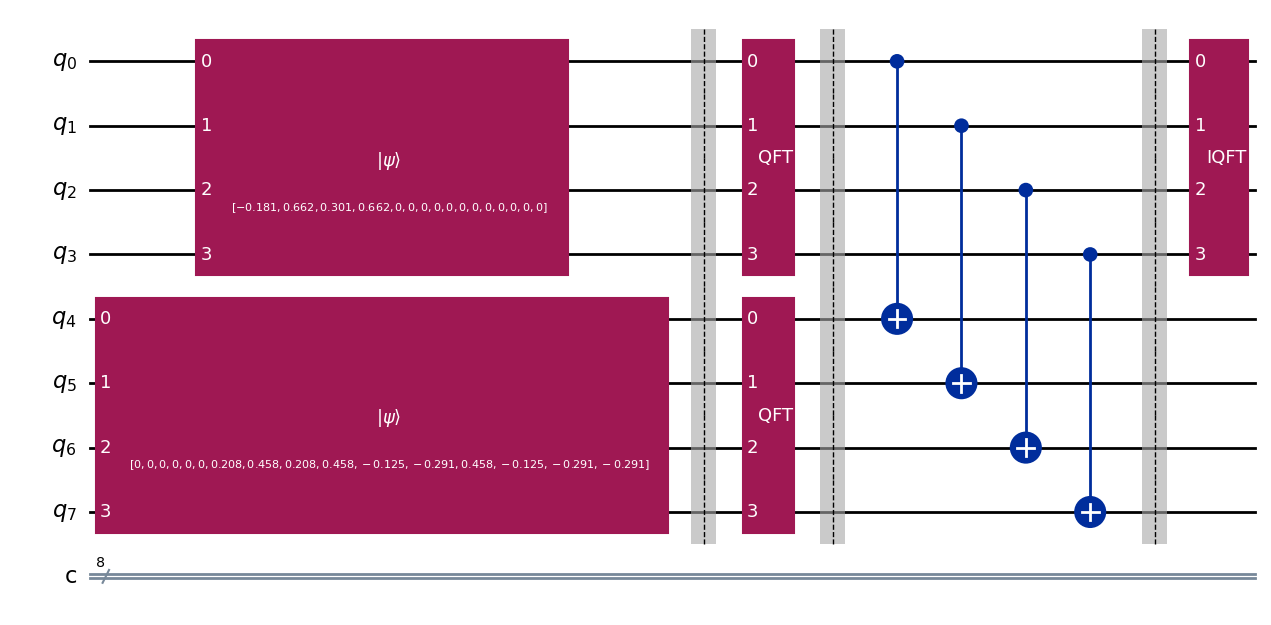

In [12]:
def make_string_match_circuit(text_state, key_state, measure=False):
    l = len(key_state)
    assert(len(key_state) == len(text_state))

    qubits = math.ceil(math.log2(l))
    qc = QuantumCircuit(2 * qubits, 2 * qubits)
    
    # Initialize with polynomial encoding
    qc.initialize(key_state, range(qubits))
    qc.initialize(text_state, range(qubits, 2 * qubits))
    qc.barrier()
    
    # Apply QFT
    key_qft = QFT(qubits)
    text_qft = QFT(qubits)
    
    qc.append(key_qft, range(qubits))
    qc.append(text_qft, range(qubits, 2 * qubits))
    qc.barrier()
    
    # Elementwise amplitude multiplication
    for i in range(qubits):
        qc.cx(i, i + qubits)

    if measure:
        qc.measure(range(qubits, 2 * qubits), range(qubits, 2 * qubits))
    qc.barrier()
    
    # Inverse QFT
    iqft = QFT(qubits, inverse=True)
    qc.append(iqft, range(qubits))

    if measure:
        qc.measure(range(qubits), range(qubits))
    
    return qc

qc = make_string_match_circuit(text_enc / text_norm, key_enc / key_norm)
qc.draw('mpl', fold=30)

### Algebraic Analysis

In [13]:
# Get output state vector
output_state = Statevector(qc).data

qubits = math.ceil(math.log2(l))
conditioned_states = output_state[:2 ** qubits]

norm = np.sqrt(sum(abs(amp)**2 for amp in conditioned_states))
norm_conditioned_states = [amp/norm for amp in conditioned_states]
probabilities = np.abs(norm_conditioned_states) ** 2
probabilities

array([1.25083290e-01, 7.46275760e-02, 3.52731902e-02, 4.42735151e-33,
       9.21945615e-33, 7.85462169e-33, 1.33858455e-03, 2.87944410e-03,
       1.02095331e-01, 1.03659988e-01, 4.53191186e-01, 5.71367379e-02,
       9.51882347e-05, 2.28689734e-02, 6.87734996e-03, 1.48731617e-02])

In [14]:
import matplotlib.pyplot as plt

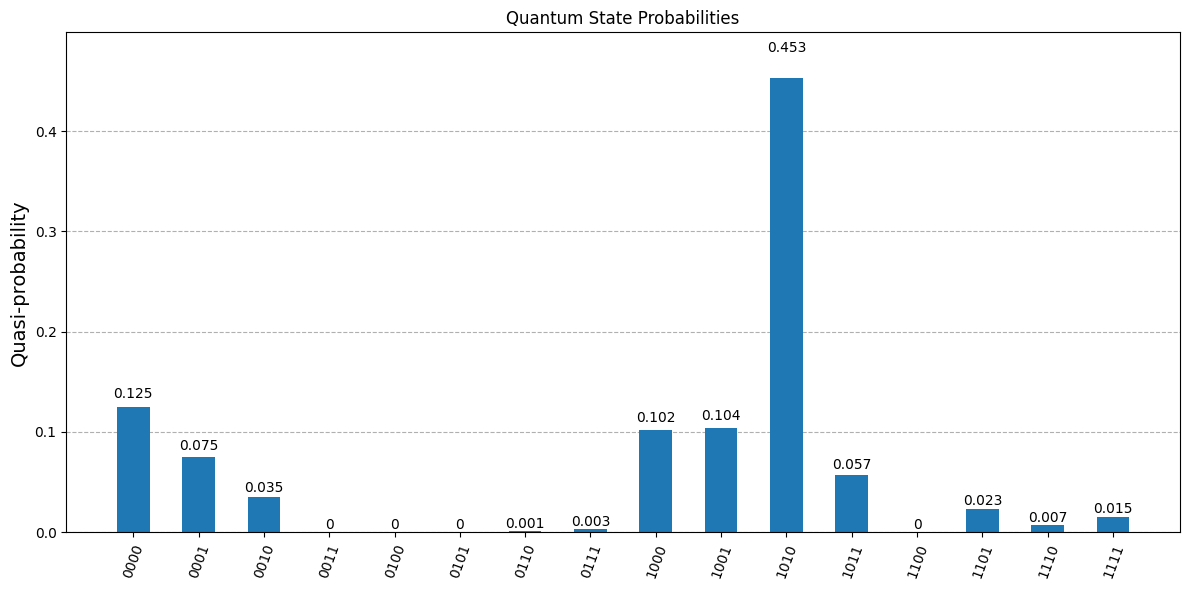

In [15]:
# Create labels as binary strings
# Also reverse the ordering since qiskit does things backwards
state_labels = [format(i, f'0{qubits}b') for i in range(2 ** qubits)]

# Create a dictionary mapping state labels to their probabilities
# This is the format expected by plot_histogram
counts_dict = {state_labels[i]: probabilities[i] for i in range(2 ** qubits)}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))
plot_histogram(counts_dict, ax=ax, title='Quantum State Probabilities')
plt.xticks(rotation=70)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [16]:
# Quantum results should match normalized classical algorithm
(res / np.linalg.norm(res)) ** 2

array([1.25083290e-01-0.j, 7.46275760e-02-0.j, 3.52731902e-02-0.j,
       0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
       1.33858455e-03-0.j, 2.87944410e-03+0.j, 1.02095331e-01+0.j,
       1.03659988e-01+0.j, 4.53191186e-01+0.j, 5.71367379e-02+0.j,
       9.51882347e-05-0.j, 2.28689734e-02+0.j, 6.87734996e-03-0.j,
       1.48731617e-02+0.j])

In [17]:
probabilities

array([1.25083290e-01, 7.46275760e-02, 3.52731902e-02, 4.42735151e-33,
       9.21945615e-33, 7.85462169e-33, 1.33858455e-03, 2.87944410e-03,
       1.02095331e-01, 1.03659988e-01, 4.53191186e-01, 5.71367379e-02,
       9.51882347e-05, 2.28689734e-02, 6.87734996e-03, 1.48731617e-02])

In [18]:
# We can also reproduce our original coefficients
res

array([-145.+0.j, -112.+0.j,  -77.+0.j,    0.+0.j,   -0.+0.j,    0.+0.j,
        -15.+0.j,   22.+0.j,  131.+0.j,  132.+0.j,  276.+0.j,   98.+0.j,
         -4.+0.j,   62.+0.j,  -34.+0.j,   50.+0.j])

In [19]:
denorm = cleanup(conditioned_states * key_norm * text_norm * 4)
denorm

array([-145.-0.j, -112.+0.j,  -77.-0.j,   -0.+0.j,   -0.-0.j,   -0.-0.j,
        -15.-0.j,   22.+0.j,  131.+0.j,  132.-0.j,  276.+0.j,   98.+0.j,
         -4.+0.j,   62.+0.j,  -34.+0.j,   50.-0.j])

In [20]:
# Index can be reconstructed 
deg = np.argwhere(res == key_fingerprint)
l - deg - 1

array([[5]], dtype=int64)

Remark: the output statevector has the same coefficients as out classical output!

### Simulator Analysis

In [21]:
sim_qc = make_string_match_circuit(text_enc / text_norm, key_enc / key_norm, measure=True)

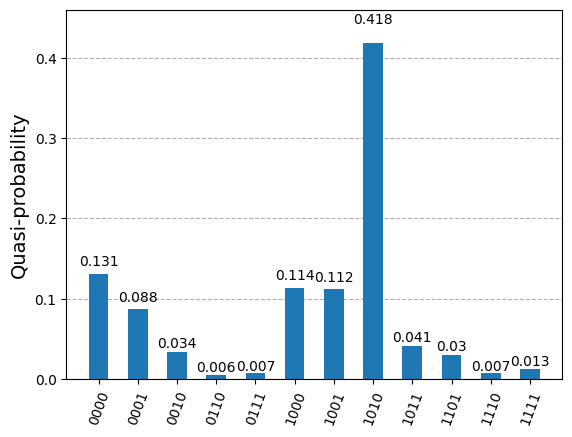

In [22]:
sampler = AerSampler()
job_sim = sampler.run([sim_qc] , shots=8192)

# Filter distribution where elementwise multiplication succeeded
dist = job_sim.result().quasi_dists[0]
pred = lambda x: x < (2 ** qubits)
dist = {format(k, f'0{2*qubits}b')[qubits:]: v for k, v in dist.items() if pred(k)}

plot_histogram(dist)

In [23]:
sorted_keys = [k for k in dist.keys()]
sorted_keys.sort()
modified_dist = [dist[k] for k in sorted_keys]

In [24]:
# Mode element
max_index = np.argmax(modified_dist)
bin_deg = sorted_keys[max_index]
bin_deg

'1010'

## Multi-String Matching

To match multiple strings, we simply add their polynomials together and search for it like before.

In [25]:
keys = [
    "ATCT",
    "GGAT",
    "ACCC"
]

text = "GGAT_GATC_TC".replace("_", "")
m = len(keys[0])
n = len(text)

# Map alphabet to polynomial coefficients
mapping = {
    "A": -3,
    "C": 5,
    "G": -7,
    "T": 11
}
l = 2 * n - m
qubits = math.ceil(math.log2(l))
l, qubits

(16, 4)

In [26]:
# Classical sanity check:
for key in keys:
    print(text.find(key))

5
0
-1


In [27]:
multi_key_enc = np.zeros(l)
for key in keys:
    multi_key_enc = multi_key_enc + encode_key(key, mapping, n, m)

text_enc = encode_text(text, mapping, n, m)

In [28]:
multi_key_norm = np.linalg.norm(multi_key_enc)
text_norm = np.linalg.norm(text_enc)

multi_qc = make_string_match_circuit(text_enc / text_norm, multi_key_enc / multi_key_norm, measure=True)

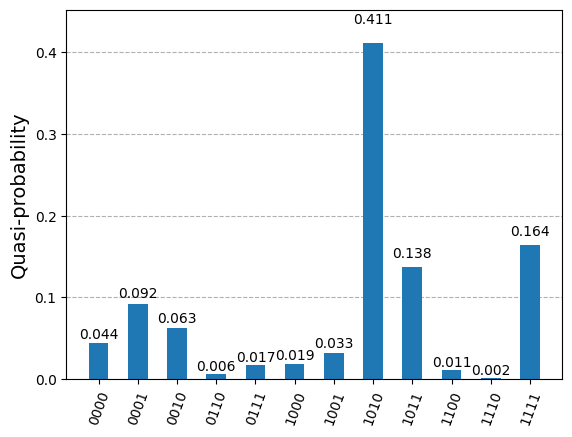

In [29]:
sampler = AerSampler()
job_sim = sampler.run([multi_qc] , shots=8192)

# Filter distribution where elementwise multiplication succeeded
dist = job_sim.result().quasi_dists[0]
pred = lambda x: x < (2 ** qubits)
dist = {format(k, f'0{2*qubits}b')[qubits:]: v for k, v in dist.items() if pred(k)}

plot_histogram(dist)

## Stress Test
The number of qubits scales logarithmically with the size of the text. We try a larger input, pushing the limitations of the quantum simulator (and our patience).

In [30]:
def make_string(str_len, alphabet):
    return "".join([np.random.choice(alphabet) for i in range(str_len)])

text = make_string(90, ['A', 'C', 'T', 'G'])
key = text[34:(34 + 52)]

n = len(text)
m = len(key)
l = 2 * n - m
qubits = math.ceil(math.log2(l))

text, key, text.find(key), l, qubits

('GGTCTGATGAATTCGGGGGATTTGTGCAGACCAGAGTCAGACCCTGTGGACATGAACGAACTATCGCCATCCCTCTTAGCCAATGCTGGC',
 'AGTCAGACCCTGTGGACATGAACGAACTATCGCCATCCCTCTTAGCCAATGC',
 34,
 128,
 7)

In [31]:
# Polynomial encode key and text
prime_mapping = {
    "A": -3,
    "C": 5,
    "G": -7,
    "T": 11
}

text_enc = encode_text(text, prime_mapping, n, m)
key_enc = encode_key(key, prime_mapping, n, m)
text_norm = np.linalg.norm(text_enc)
key_norm = np.linalg.norm(key_enc)

assert(len(text_enc) == len(key_enc) == l)
l

128

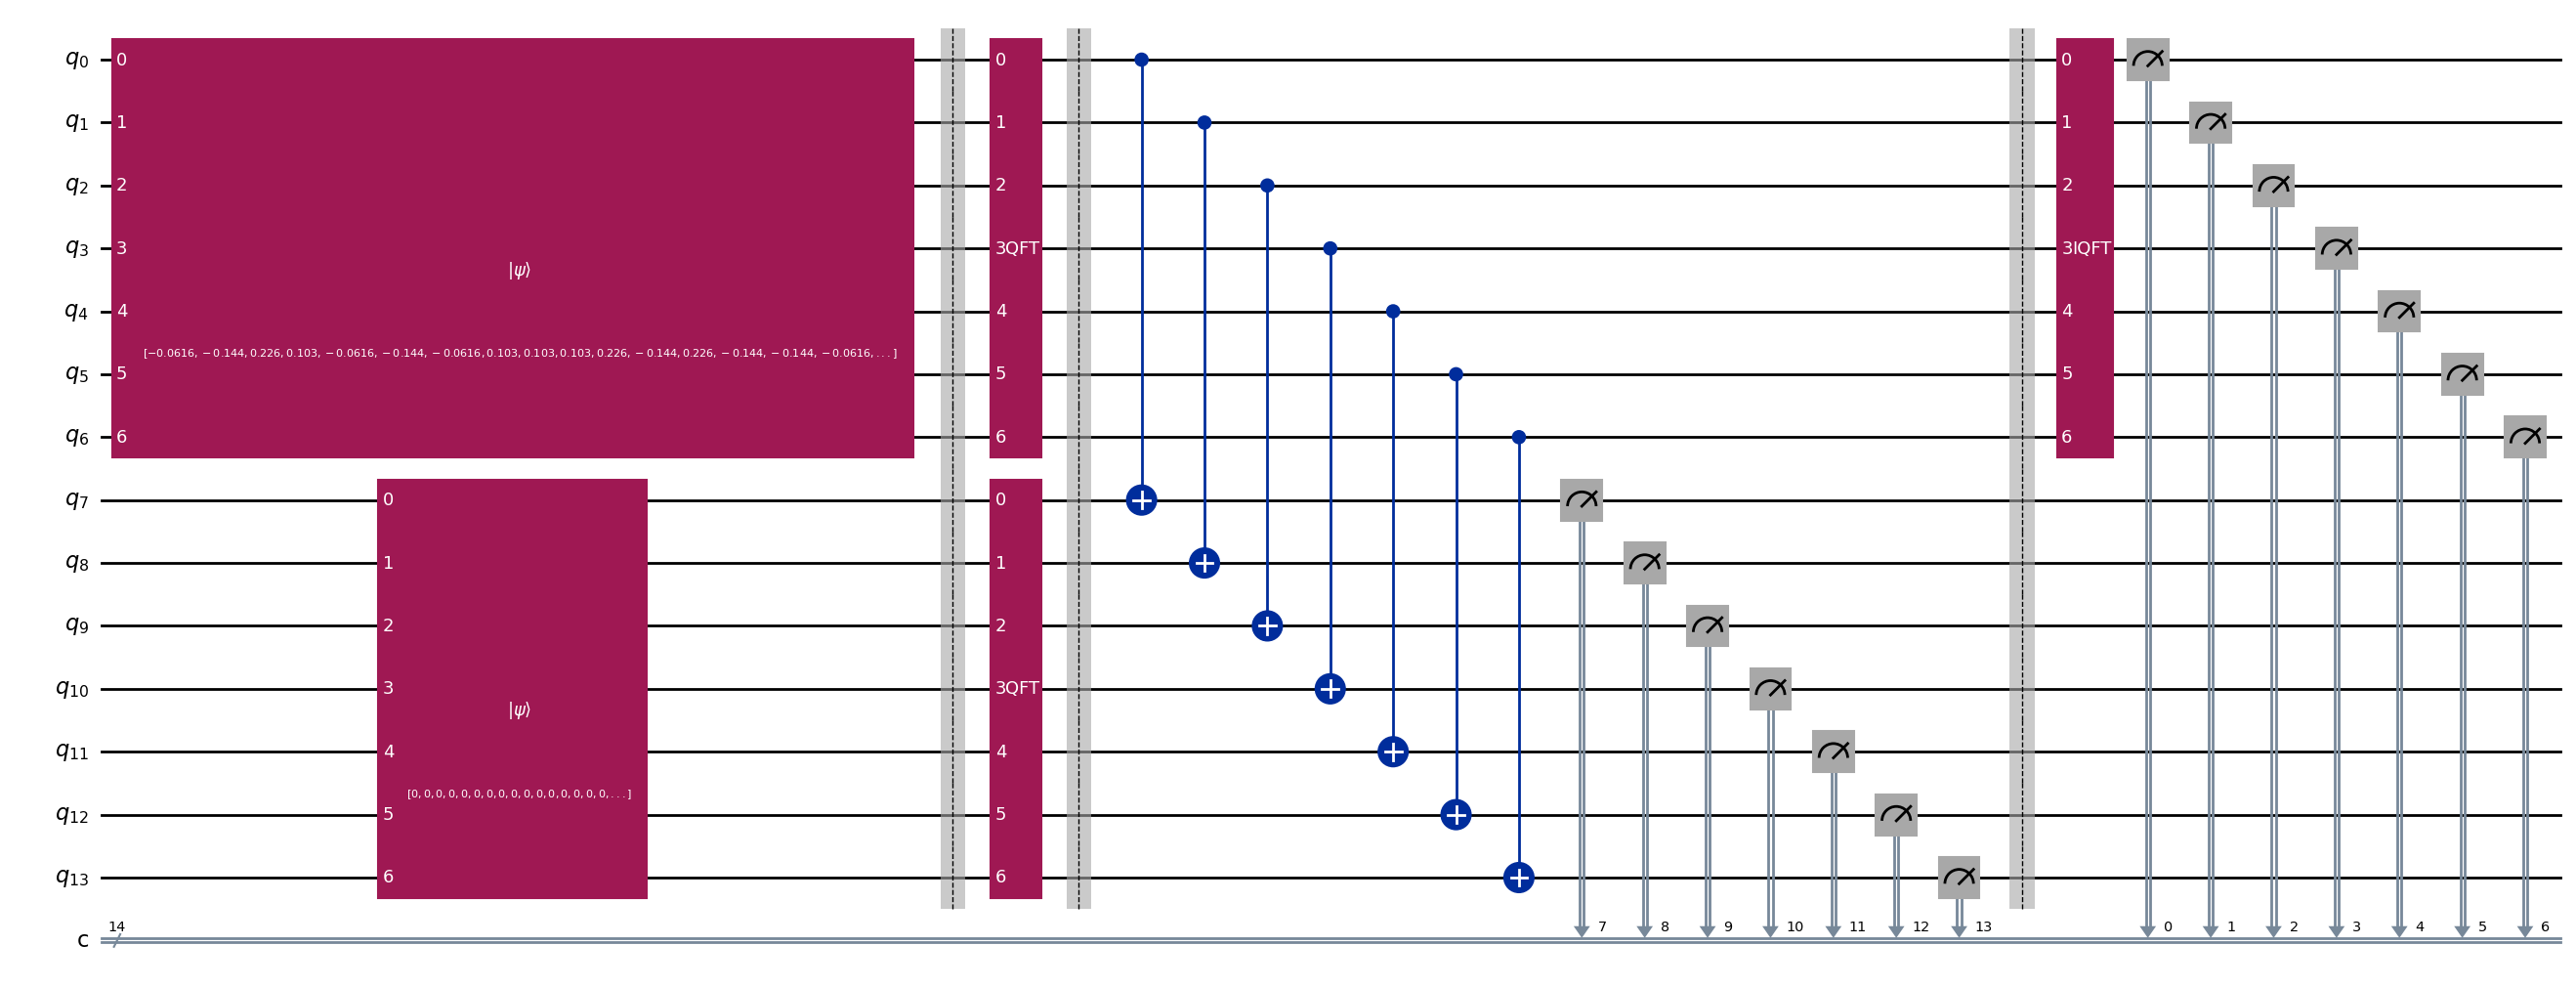

In [32]:
stress_qc = make_string_match_circuit(text_enc / text_norm, key_enc / key_norm, measure=True)
stress_qc.draw("mpl", fold=60)

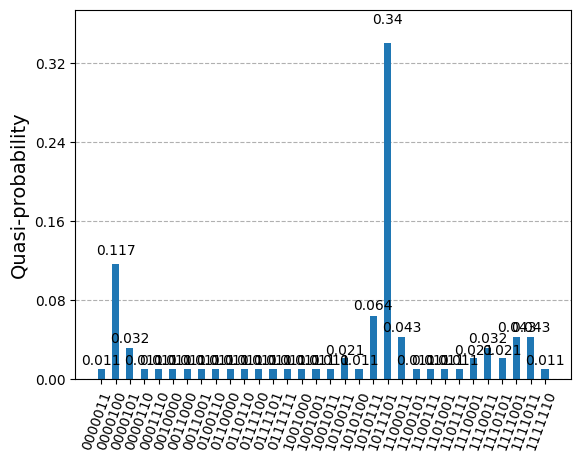

In [33]:
sampler = AerSampler()
job_sim = sampler.run([stress_qc] , shots=8192)

# Filter distribution where elementwise multiplication succeeded
dist = job_sim.result().quasi_dists[0]
pred = lambda x: x < (2 ** qubits)
dist = {format(k, f'0{2*qubits}b')[qubits:]: v for k, v in dist.items() if pred(k)}

plot_histogram(dist)

In [34]:
# You *can* read the correct result from the graph but it's tricky.
# If we just extract the idnex with the highest probability, and then subtract from l - 1,
# we get the search index!
sorted_keys = [k for k in dist.keys()]
sorted_keys.sort()
modified_dist = [dist[k] for k in sorted_keys]

max_index = np.argmax(modified_dist)
bin_deg = sorted_keys[max_index]
deg = int(bin_deg, 2)
l - deg - 1

34

Note that the same analytical approach also works (and achieves the same result), and is *significantly* faster to run than the Aer simulator.

In [35]:
# Make a circuit without measurement for direct state vector output read
stress_qc_raw = make_string_match_circuit(text_enc / text_norm, key_enc / key_norm)
output_state = Statevector(stress_qc_raw).data

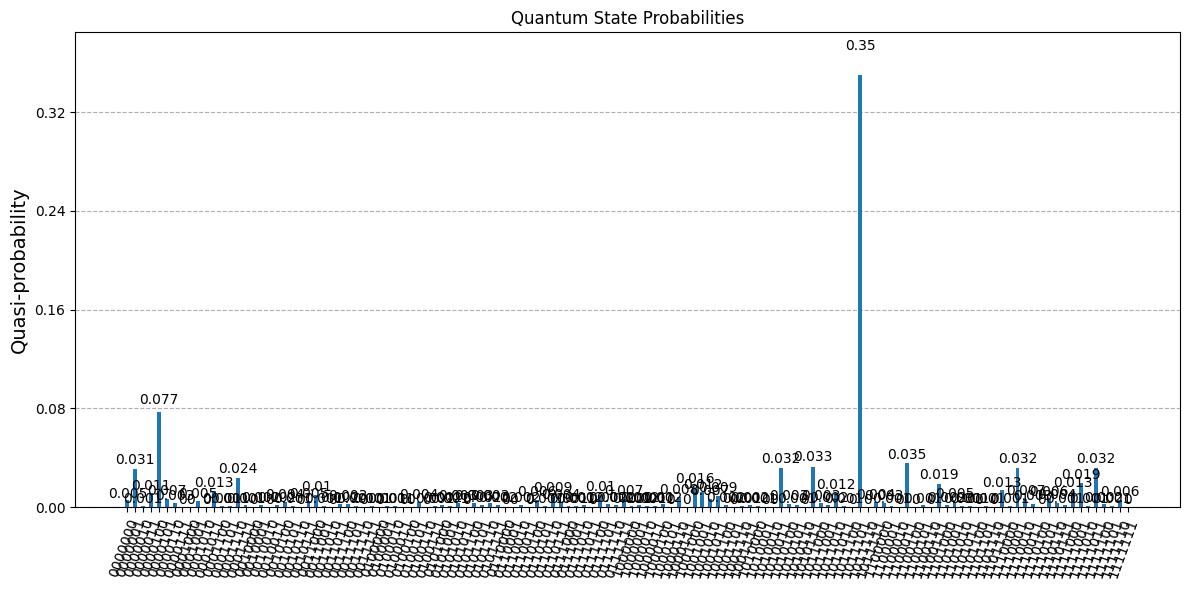

In [36]:
# Analyze resulting state vector, plot
conditioned_states = output_state[:2 ** qubits]
norm = np.sqrt(sum(abs(amp)**2 for amp in conditioned_states))
norm_conditioned_states = [amp/norm for amp in conditioned_states]
probabilities = np.abs(norm_conditioned_states) ** 2
probabilities

# Create labels as binary strings
# Also reverse the ordering since qiskit does things backwards
state_labels = [format(i, f'0{qubits}b') for i in range(2 ** qubits)]

# Create a dictionary mapping state labels to their probabilities
# This is the format expected by plot_histogram
counts_dict = {state_labels[i]: probabilities[i] for i in range(2 ** qubits)}

# Plot the histogram
fig, ax = plt.subplots(figsize=(12, 6))
plot_histogram(counts_dict, ax=ax, title='Quantum State Probabilities')
plt.xticks(rotation=70)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

In [37]:
# Extract the desired states and pick the one with the highest probability amplitude
deg = np.argmax(np.abs(conditioned_states))
l - deg - 1

34

In [38]:
# Same idea works if analyzing probabilities
deg = np.argmax(probabilities)
l - deg - 1

34

## Experimental Section

In [39]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

# Define our input states coefficients in arrays
# For |ψ_in^(1)⟩ = α_00|00⟩ + α_01|01⟩ + α_10|10⟩ + α_11|11⟩
alpha = np.array([0.3, 0.4, 0.5, 0.6])  # [α_00, α_01, α_10, α_11]

# For |ψ_in^(2)⟩ = β_00|00⟩ + β_01|01⟩ + β_10|10⟩ + β_11|11⟩
beta = np.array([0.2, 0.3, 0.7, 0.4])   # [β_00, β_01, β_10, β_11]

# Normalize both input states
alpha = alpha / np.linalg.norm(alpha)
beta = beta / np.linalg.norm(beta)

print(f"Normalized α coefficients: {alpha}")
print(f"Normalized β coefficients: {beta}")

# Calculate the expected element-wise multiplication
expected = alpha * beta

# Normalize the expected output
expected = expected / np.linalg.norm(expected)

print(f"Expected normalized output coefficients: {expected}")

Normalized α coefficients: [0.32349832 0.43133109 0.53916387 0.64699664]
Normalized β coefficients: [0.22645541 0.33968311 0.79259392 0.45291081]
Expected normalized output coefficients: [0.13480593 0.26961187 0.78636795 0.53922374]


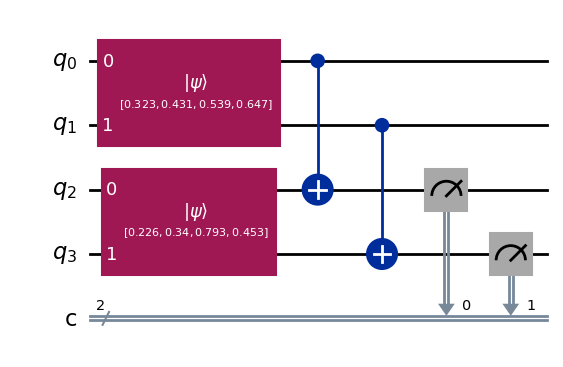

In [40]:
qr = QuantumRegister(4, 'q')  # q[0], q[1] for first register, q[2], q[3] for second register
cr = ClassicalRegister(2, 'c')  # 2 classical bits to measure the second register
circuit = QuantumCircuit(qr, cr)

# Initialize the first register to |ψ_in^(1)⟩
circuit.initialize(alpha, [qr[0], qr[1]])

# Initialize the second register to |ψ_in^(2)⟩
circuit.initialize(beta, [qr[2], qr[3]])

# Apply CNOT gates between corresponding qubits as shown in the figure
# This implements the element-wise multiplication
circuit.cx(qr[0], qr[2])  # CNOT from q[0] to q[2]
circuit.cx(qr[1], qr[3])  # CNOT from q[1] to q[3]

# Measure the second register (qubits 2 and 3)
circuit.measure([qr[2], qr[3]], [cr[0], cr[1]])
circuit.draw('mpl')

In [41]:
circuit_no_measure = circuit.copy()
circuit_no_measure.remove_final_measurements()

In [42]:
statevector = Statevector(circuit_no_measure).data
statevector

array([0.07325794+0.j, 0.14651589+0.j, 0.427338  +0.j, 0.29303177+0.j,
       0.10988692+0.j, 0.09767726+0.j, 0.24419315+0.j, 0.51280561+0.j,
       0.2564028 +0.j, 0.19535452+0.j, 0.12209657+0.j, 0.21977383+0.j,
       0.14651589+0.j, 0.3418704 +0.j, 0.18314486+0.j, 0.14651589+0.j])

In [43]:
filtered = statevector[0:4]
filtered / np.linalg.norm(filtered)

array([0.13480593+0.j, 0.26961187+0.j, 0.78636795+0.j, 0.53922374+0.j])

In [44]:
expected

array([0.13480593, 0.26961187, 0.78636795, 0.53922374])

In [45]:
# take the first 4